# Import data and libraries

In [1]:
import sys
sys.path.append('..')
import scripts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

tree_data = pd.read_csv('../../data/covtype.data', header=None)
tree_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_To_Hydrology',
             'Vertical_To_Hydrology', 'Horizontal_To_Roadways',
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
             'Horizontal_To_Fire'] + \
            [f'Wilderness_Area_{i}' for i in range(4)] + \
            [f'Soil_Type_{i}' for i in range(40)] + \
            ['Cover_Type']

# print(tree_data.describe())
tree_data.columns = tree_cols
print("Nan values in dataset:", tree_data.isna().sum().sum())
print(tree_data.head())

2025-11-30 15:51:25.311395: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Nan values in dataset: 0
   Elevation  Aspect  Slope  Horizontal_To_Hydrology  Vertical_To_Hydrology  \
0       2596      51      3                      258                      0   
1       2590      56      2                      212                     -6   
2       2804     139      9                      268                     65   
3       2785     155     18                      242                    118   
4       2595      45      2                      153                     -1   

   Horizontal_To_Roadways  Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0                     510            221             232            148   
1                     390            220             235            151   
2                    3180            234             238            135   
3                    3090            238             238            122   
4                     391            220             234            150   

   Horizontal_To_Fire  ...  Soil_Type_31  Soil_Ty

## Split training/testing data

In [2]:
x_tree = tree_data.drop('Cover_Type', axis=1)
y_tree = tree_data['Cover_Type']

x_train, x_test, y_train, y_test = train_test_split(x_tree, y_tree, test_size=0.2)


x_underSampled, y_underSampled = RandomUnderSampler(random_state=42, sampling_strategy='majority').fit_resample(x_train, y_train)

x_underSampled = x_underSampled.to_numpy()
y_underSampled = y_underSampled.to_numpy()

data = tree_data.to_numpy()

## Class Distribution

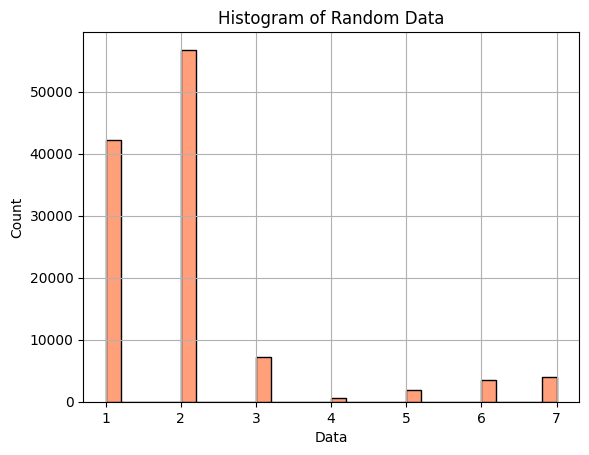

In [3]:
plt.hist(y_test, bins=30, color='lightsalmon', edgecolor='black')
plt.xlabel('Data')
plt.ylabel('Count')
plt.title('Histogram of Random Data')
plt.grid(True)
plt.show()

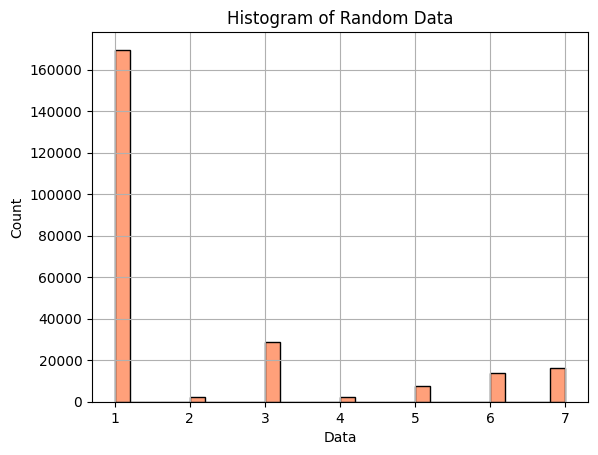

In [4]:
plt.hist(y_underSampled, bins=30, color='lightsalmon', edgecolor='black')
plt.xlabel('Data')
plt.ylabel('Count')
plt.title('Histogram of Random Data')
plt.grid(True)
plt.show()


## Scaling Dataset

In [5]:
scalar = StandardScaler()

scaled = scalar.fit_transform(x_underSampled[:, :10])

dataScaled = np.concatenate((scaled, x_underSampled[:,10:54]), axis=1)

x_Scaled_train, x_Scaled_test, y_Scaled_train, y_Scaled_test = train_test_split(dataScaled, y_underSampled.reshape(-1, 1), test_size=0.2)

## AdaBoost with balanced class weights

In [6]:
ab = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=13, class_weight='balanced'), n_estimators=100)
ab.fit(x_Scaled_train, y_Scaled_train.ravel())
print("Z Scaled Test Accuracy: ", ab.score(x_Scaled_test, y_Scaled_test))


Z Scaled Test Accuracy:  0.979248107793396


## AdaBoost

In [7]:

ab = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100)
ab.fit(x_Scaled_train, y_Scaled_train.ravel())
print("Z Scaled Test Accuracy: ", ab.score(x_Scaled_test, y_Scaled_test))


Z Scaled Test Accuracy:  0.9797471512933544


## GridSearch with balanced class weights

In [8]:

mcc_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)
param_grid = {"estimator": [DecisionTreeClassifier(max_depth=7, class_weight='balanced'), DecisionTreeClassifier(max_depth=9, class_weight='balanced'), \
                            DecisionTreeClassifier(max_depth=11, class_weight='balanced'), DecisionTreeClassifier(max_depth=13, class_weight='balanced')], \
"n_estimators": [25, 50, 75, 100]}

model_ABB = AdaBoostClassifier()

grid_searchABB = GridSearchCV(model_ABB, param_grid, cv=3, scoring=mcc_scorer, verbose=10, n_jobs=8)
grid_searchABB.fit(x_Scaled_train, y_Scaled_train.ravel())

print(grid_searchABB.best_params_, grid_searchABB.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[CV 1/3; 2/16] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50
[CV 3/3; 2/16] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50
[CV 3/3; 1/16] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=25
[CV 1/3; 3/16] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=75
[CV 1/3; 1/16] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=25
[CV 2/3; 1/16] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=25
[CV 2/3; 2/16] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50
[CV 2/3; 3/16] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=75
[CV 1/3; 1/16] END estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=25;, score=0.675 total t

## GridSearch without class weights

In [9]:

mcc_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)
param_grid = {"estimator": [DecisionTreeClassifier(max_depth=7), DecisionTreeClassifier(max_depth=9), \
                            DecisionTreeClassifier(max_depth=11), DecisionTreeClassifier(max_depth=13)], \
"n_estimators": [25, 50, 75, 100]}

model_ab = AdaBoostClassifier()

grid_searchAB = GridSearchCV(model_ab, param_grid, cv=3, scoring=mcc_scorer, verbose=10, n_jobs=8)
grid_searchAB.fit(x_Scaled_train, y_Scaled_train.ravel())

print(grid_searchAB.best_params_, grid_searchAB.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3; 1/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25
[CV 2/3; 1/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25
[CV 3/3; 1/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25
[CV 1/3; 2/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 2/3; 2/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 3/3; 2/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 1/3; 3/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75
[CV 2/3; 3/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75
[CV 1/3; 1/16] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=25;, score=0.748 total time=  38.3s
[CV 3/3; 3/16] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=75
[CV 3/3; 1/16] END estimator=DecisionTreeClassifier(max_depth=7), n_

# Evaluation

In [2]:
from sklearn.metrics import accuracy_score
import os

best_ab = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100)

def load_evaluate_model(model, prefix, output_dir='../resources/outputs'):
    print(f"Evaluating model for prefix: {prefix}")
    if prefix not in ['one_under', 'two_under', 'over_under']:
        raise ValueError("Prefix must be one of 'one_under', 'two_under', or 'over_under'")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    training_data, validation_data, test_data = scripts.load_processed_data('../../data', prefix=prefix)
    training_data = pd.concat([training_data, validation_data])
    x_train, y_train = training_data.drop('Cover_Type', axis=1), training_data['Cover_Type']
    x_test, y_test = test_data.drop('Cover_Type', axis=1), test_data['Cover_Type']
    print(f"Data loaded for {prefix}")

    model.fit(x_train, y_train)

    print(f"Model trained for {prefix}")
    y_pred = model.predict(x_test)
    cmd, mcList, class_report, mcc = scripts.evaluate(y_test, y_pred)
    cmd.plot()
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    print("Classification Report:\n", class_report)

    print(f"Completed evaluation for prefix: {prefix}\n")

Evaluating model for prefix: one_under
Data loaded for one_under
Data loaded for one_under
Model trained for one_under
Model trained for one_under
Accuracy: 0.9037
Matthews Correlation Coefficient: 0.8574
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.90     21184
           1       0.99      0.82      0.90     28331
           2       0.91      0.98      0.94      3575
           3       0.92      0.88      0.90       275
           4       0.77      0.95      0.85       949
           5       0.89      0.94      0.91      1737
           6       0.97      0.97      0.97      2051

    accuracy                           0.90     58102
   macro avg       0.90      0.93      0.91     58102
weighted avg       0.92      0.90      0.90     58102

Completed evaluation for prefix: one_under

Evaluating model for prefix: two_under
Accuracy: 0.9037
Matthews Correlation Coefficient: 0.8574
Classification Report:
          

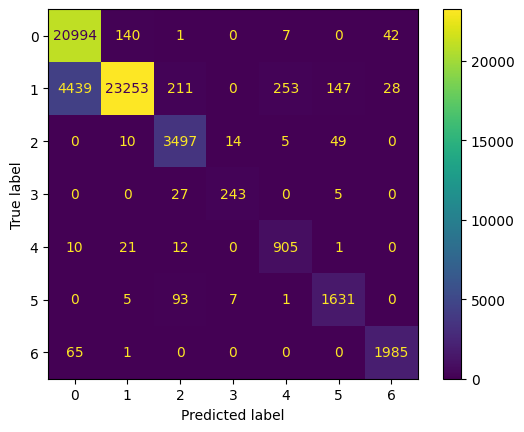

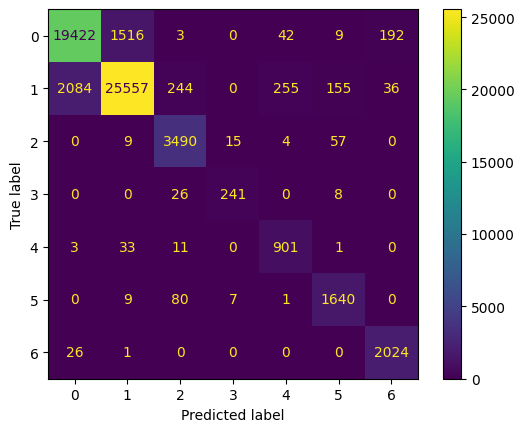

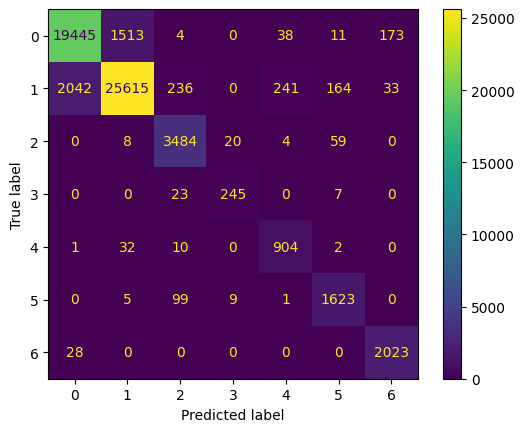

In [3]:
for prefix in ['one_under', 'two_under', 'over_under']:
    load_evaluate_model(best_ab, prefix)